In [1]:
import csv
import pandas as pd
import numpy as np
import datetime
import matplotlib
import pyflux as pf
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

In [2]:
def make_pitt_weather_dataframe(filepath):
    l = []
    with open(filepath, 'r', encoding = 'utf-8') as csvfile:
        data = csv.reader(csvfile, delimiter=',', quotechar='"')
        header = next(data, None)
        for row in data:
            row[2] = pd.to_datetime(row[2])
            row[3] = int(row[3]) 
            l += [tuple(row)] 
    return(pd.DataFrame(l, columns = header))

data = make_pitt_weather_dataframe("/Users/AllisonBlack/Dropbox/15-388/Tutorial/Pitt_weather_data.csv")
print(data.head())
date_temp = data[["DATE", "TAVG"]]
print(data.dtypes)

       STATION                    NAME       DATE  TAVG
0  USW00094823  PITTSBURGH ASOS, PA US 2015-01-01    25
1  USW00094823  PITTSBURGH ASOS, PA US 2015-01-02    31
2  USW00094823  PITTSBURGH ASOS, PA US 2015-01-03    32
3  USW00094823  PITTSBURGH ASOS, PA US 2015-01-04    53
4  USW00094823  PITTSBURGH ASOS, PA US 2015-01-05    24
STATION            object
NAME               object
DATE       datetime64[ns]
TAVG                int64
dtype: object


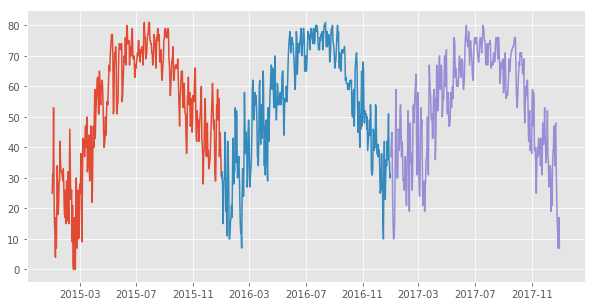

In [3]:
l = []
l.append(plt.plot(data.DATE[:366], data.TAVG[:366])[0])
l.append(plt.plot(data.DATE[365:731], data.TAVG[365:731])[0])
l.append(plt.plot(data.DATE[731:], data.TAVG[731:])[0])
plt.show()

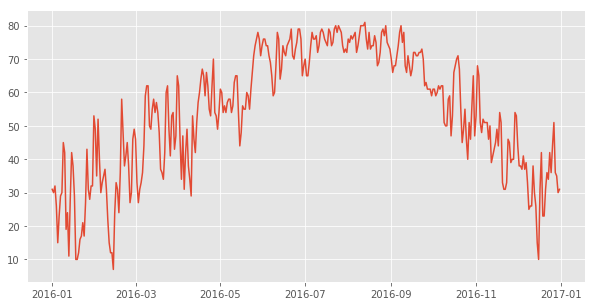

In [4]:
plt.plot(data.DATE[365:731], data.TAVG[365:731])
plt.show()

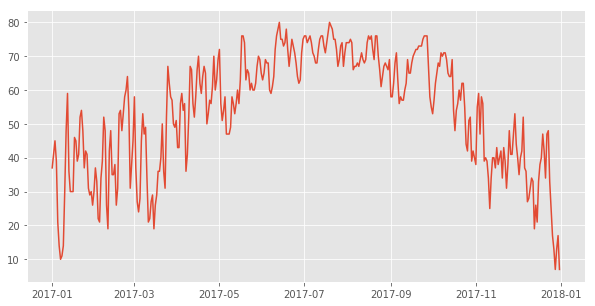

In [5]:
plt.plot(data.DATE[731:], data.TAVG[731:])
plt.show()

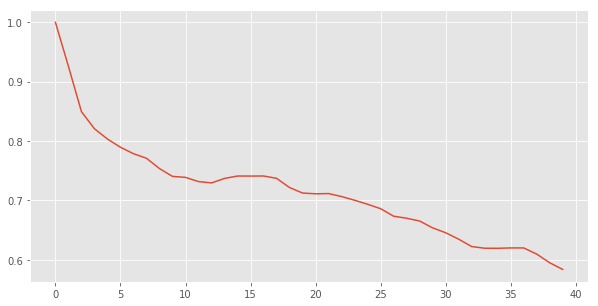

In [6]:
corrs = []
for i in range(40):
    corrs += [data.TAVG.autocorr(i)]
corrs = pd.Series(corrs)
plt.plot(corrs)

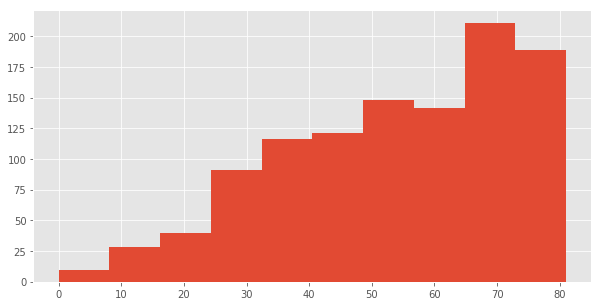

In [7]:
data.TAVG.hist()
plt.show()

In [8]:
x = data["TAVG"]
x = pd.Series(np.log(x))

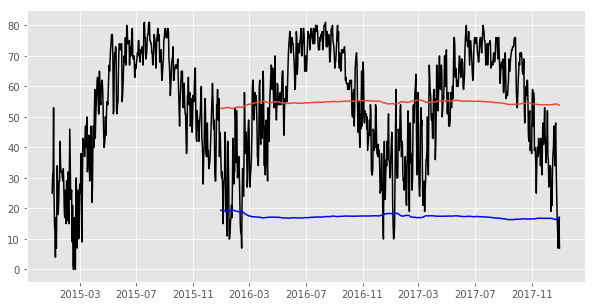

In [9]:
rolling_mean = pd.rolling_mean(data.TAVG, window = 365)
rolling_std = pd.rolling_std(data.TAVG, window = 365)
plt.plot(data.DATE, data.TAVG, color = "black")
plt.plot(data.DATE, rolling_std, color = "blue")
plt.plot(data.DATE, rolling_mean)
plt.show()

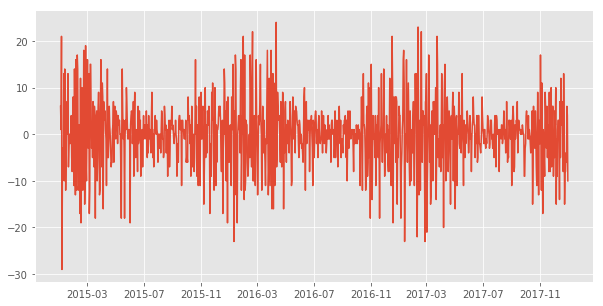

In [10]:
data['first_diff'] = data.TAVG - data.TAVG.shift(1)
plt.plot(data.DATE[1:], data.first_diff[1:])
plt.show()

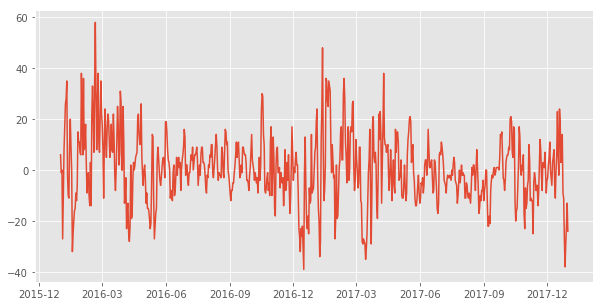

In [11]:
data['season_diff'] = data.TAVG - data.TAVG.shift(365)
data['season_diff'] = data.season_diff.dropna(inplace = False)
plt.plot(data.DATE, data.season_diff)
plt.show()

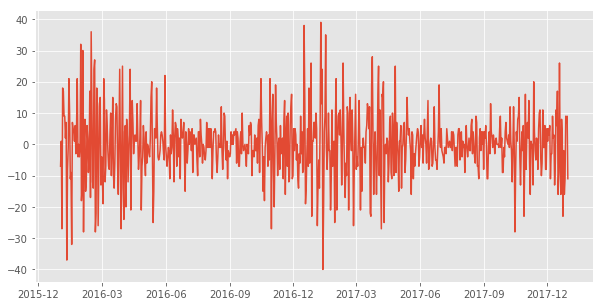

In [12]:
data['season_first_diff'] = data.first_diff - data.first_diff.shift(365)
data['season_first_diff'] = data.season_first_diff.dropna(inplace = False)
plt.plot(data.DATE, data.season_first_diff)
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace import sarimax

In [35]:
adfuller(data.TAVG)

(-1.728497542422649,
 0.41649270938332772,
 20,
 1075,
 {'1%': -3.4364476591811033,
  '10%': -2.5682035004867494,
  '5%': -2.8642323472116922},
 7017.1893752048409)

In [34]:
adfuller(data.first_diff[1:])

(-10.413639631245545,
 1.777466071516495e-18,
 19,
 1075,
 {'1%': -3.4364476591811033,
  '10%': -2.5682035004867494,
  '5%': -2.8642323472116922},
 7012.5638252199224)

In [36]:
adfuller(data.season_diff[365:])

(-9.1607899789350764,
 2.5364039401352755e-15,
 2,
 728,
 {'1%': -3.4393644334758475,
  '10%': -2.5688884869731918,
  '5%': -2.8655182850048306},
 5124.4734050811348)

In [37]:
adfuller(data.season_first_diff[366:])

(-10.207706839451653,
 5.746031908863542e-18,
 17,
 712,
 {'1%': -3.4395677423210493,
  '10%': -2.5689362152032573,
  '5%': -2.8656078730509784},
 5150.1841682694203)

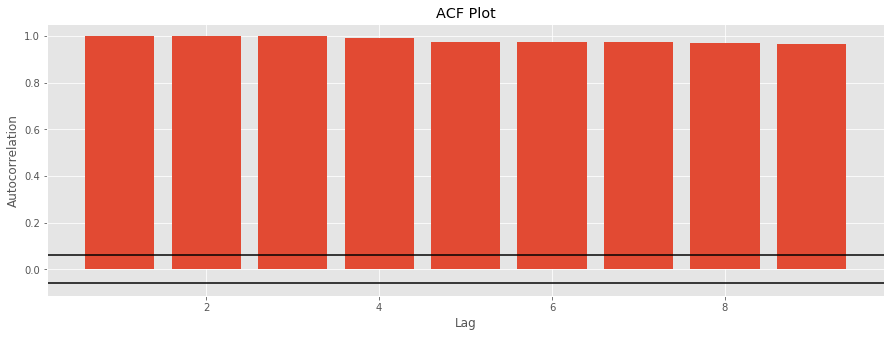

In [18]:
pf.acf_plot(data.first_diff)

In [77]:
model = pf.ARIMA(data=data[1:], ar=2, ma=0, target='first_diff')

In [78]:
x = model.fit("MLE")
x.summary()

Normal ARIMA(2,0,0)                                                                                       
======================================================= ==================================================
Dependent Variable: first_diff                          Method: MLE                                       
Start Date: 3                                           Log Likelihood: -3625.5325                        
End Date: 1095                                          AIC: 7259.0649                                    
Number of observations: 1093                            BIC: 7279.0516                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0263    0.2018     -0.1302  0.8964   (-0.4219 | 0.3693)       
AR(1)                                

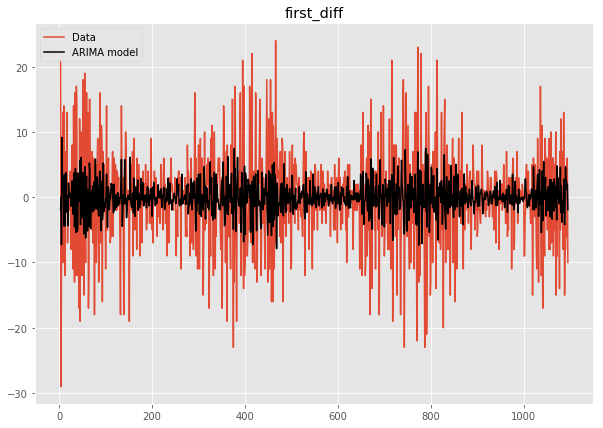

In [79]:
model.plot_fit()

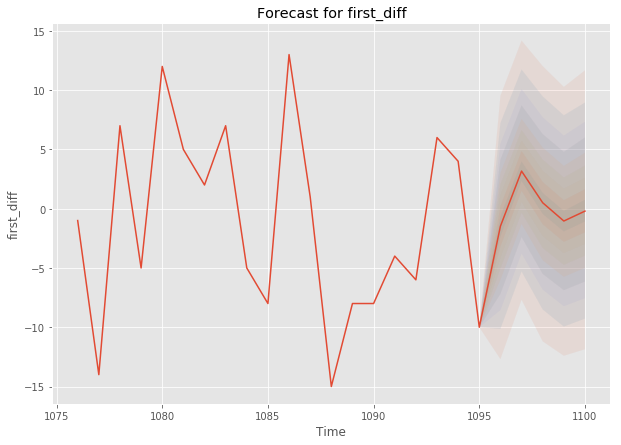

In [80]:
model.plot_predict()

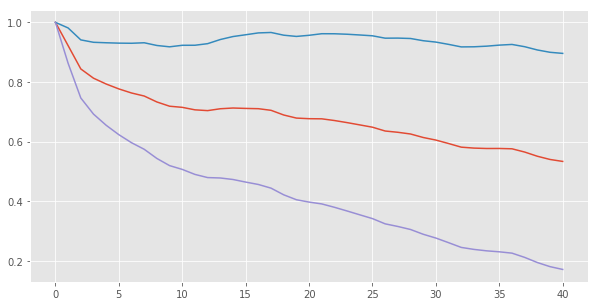

In [23]:
line, conf = acf(x = data.TAVG, alpha = 0.05)
upper = []
lower = []
for i in range(len(conf)):
    upper += [conf[i][1]]
    lower += [conf[i][0]]
plt.plot(line)
plt.plot(upper)
plt.plot(lower)
plt.show()

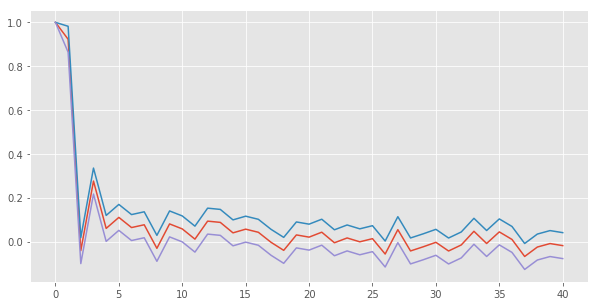

In [24]:
line, conf = pacf(x = data.TAVG, alpha = 0.05)
upper = []
lower = []
for i in range(len(conf)):
    upper += [conf[i][1]]
    lower += [conf[i][0]]
plt.plot(line)
plt.plot(upper)
plt.plot(lower)
plt.show()

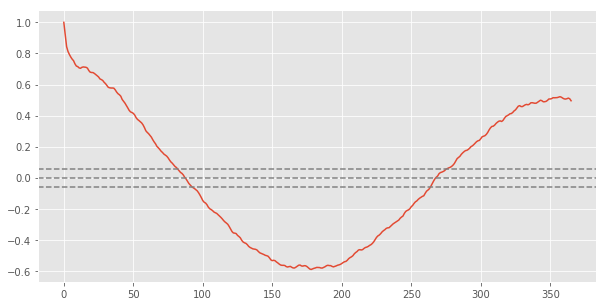

In [25]:
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
lag_acf = acf(data.TAVG, nlags = 365)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.show()

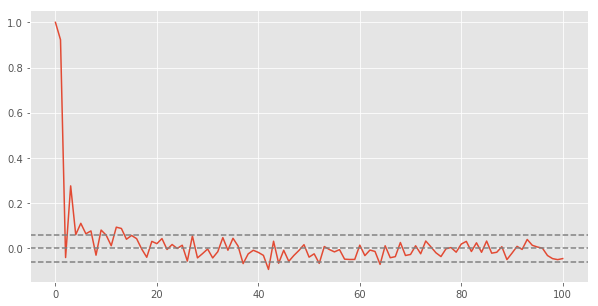

In [26]:
lag_pacf = pacf(data.TAVG, nlags = 100)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.show()

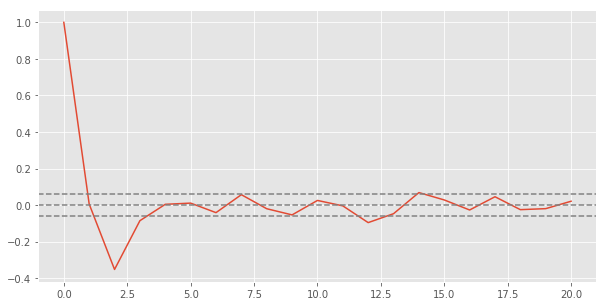

0.0592039651464
[ 1.          0.00616507 -0.3515921 ]


In [27]:
lag_acf = acf(data.season_first_diff[366:], nlags = 20)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data.first_diff[1:])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data.first_diff[1:])),linestyle='--',color='gray')
plt.show()
print(1.96/np.sqrt(len(data.TAVG)))
print(lag_acf[0:3])

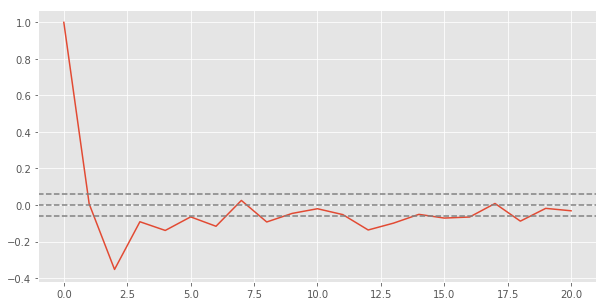

0.0592039651464
[ 1.          0.00617352 -0.35260957]


In [28]:
lag_pacf = pacf(data.season_first_diff[366:], nlags = 20)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data.TAVG)),linestyle='--',color='gray')
plt.show()
print(1.96/np.sqrt(len(data.TAVG)))
print(lag_pacf[0:3])

In [29]:
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#mod = sarimax(data.season_first_diff[366:], trend='n', order=(1,0,0), seasonal_order=(1,1,1,365))
